In [39]:
import pandas as pd
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import os
import json
from shapely.geometry import MultiPolygon, Polygon
import ntpath
from rasterio import mask
from PIL import Image
import pyfeats as ft
from sklearn.linear_model import LinearRegression
import seaborn as sns
import cv2
from scipy import ndimage
import math

In [2]:
def make_shape(coords):
    pol1 = Polygon(coords)
    mplo1 = MultiPolygon([pol1])

    return mplo1.geoms


# This block contains the functions for the VI calculations
def calculate_vdvi(red, green, blue):
    return round((2 * green - red - blue) / (2 * green + red + blue), 3)


def calculate_excess_greenness_index(red, green, blue):
    return round(2 * green - (red + blue), 2)


def calculate_cive(red, green, blue):

    return round(0.441 * red - 0.811 * green + 0.385 * blue + 18.78745, 2)


def calculate_normalized_difference_index(red, green):
    """
    Calculates the normalized difference index of an image
    """
    return round(128 * ((green - red) / (green + red)) + 1, 2)


def calculate_vegetative_index(red, green, blue):
    return round(green / ((red**0.667) * (blue**0.333)), 2)


def calculate_ngrdi(red, green):
    return round((green - red) / (green + red), 2)


## fucntions to read the grids from a geojson file
def read_grid(gpath):
    """This function recives a path for the geojson grid and reads the multipoligon puts it in a
    dictionary where the keys are the ids of the plots and the values are the coords"""

    dics = {}
    if gpath.split(".")[1] == "geojson":
        plotgrids = open(gpath)
        plotgrids = json.load(plotgrids)
        crs_coords = plotgrids["crs"]["properties"]["name"]

        for p in plotgrids["features"]:
            dics[str(p["properties"]["fid"])] = p["geometry"]["coordinates"][0]

        return crs_coords, dics

    else:
        print("It's not a geojson file")
        return


def check_crop_angle(rst_path, gpath, rangle=0, crop=(), plotpos=0, to_uint8=False):
    """This function recives a raster path and a grid path, it also recives an angle, crop and cropid input
    this function was thought to test the parameters of crop and rangle to load them after in the function to
    extract fueatures. It returns the rangle parameter and the crop parameter"""

    plotgrids = open(gpath)
    plotgrids = json.load(plotgrids)
    pol1 = Polygon(plotgrids["features"][plotpos]["geometry"]["coordinates"][0])
    mpol1 = MultiPolygon([pol1])

    with rasterio.open(rst_path) as src:
        masked_rast, _ = rasterio.mask.mask(src, shapes=mpol1.geoms, crop=True)

    red = masked_rast[0]
    green = masked_rast[1]
    blue = masked_rast[2]
    bands_stacked = np.dstack([red, green, blue])
    if to_uint8:
        bands_stacked_norm = (
            bands_stacked / bands_stacked.max()
        )  # normalizes data in range 0 - 255
        bands_stacked_norm = 255 * bands_stacked_norm
        img = Image.fromarray(bands_stacked_norm.astype(np.uint8))
    else:
        img = Image.fromarray(bands_stacked)

    if len(crop) == 4:
        plt.imshow(img.rotate(rangle).crop(crop))
        dim = img.rotate(rangle).crop(crop).size
        print(f"Image dimentions: {dim}")
        print(f"Angle applied: {rangle}")
        print(f"Croping applied: {crop}")
        return rangle, crop

    else:
        plt.imshow(img.rotate(rangle))
        dim = img.rotate(rangle).size
        print(f"Image dimentions: {dim}")
        return rangle, crop


def extract_image_from_raster(raster_data, multiplot, rangle, crop):
    """This funcion recives as input the data of a raster and  in this case a multiplot that contains only
    one plot from. It returns the image of the plot"""

    masked_rast, aff = rasterio.mask.mask(raster_data, multiplot.geoms, crop=True)

    red = masked_rast[0]
    green = masked_rast[1]
    blue = masked_rast[2]
    bands_stacked = np.dstack([red, green, blue])
    bands_stacked_norm = (
        bands_stacked / bands_stacked.max()
    )  # normalizes data in range 0 - 255
    bands_stacked_norm = 255 * bands_stacked_norm
    img = Image.fromarray(bands_stacked_norm.astype(np.uint8), "RGB")

    if len(crop) == 4:
        return img.rotate(rangle).crop(crop)
    else:
        return img.rotate(rangle)


def extract_raster_data(rasta_path, grid_path, rangle, crop):
    """This function extracts the vegetation index and the texture index of each celd from the grid
    and return a dictionary. Takes as input a raster input file and a grid geojason file, an angle
     for the celd and a cropping dimentions."""

    grid_crs, grids = read_grid(grid_path)
    valriables_dic = {
        "fid": [],
        "Date": [],
        "VDVI": [],
        "EGI": [],
        "CIVE": [],
        "NDI": [],
        "VI": [],
        "NGRDI": [],
        "GLCM_ASM_Mean": [],
        "GLCM_Contrast_Mean": [],
        "GLCM_Correlation_Mean": [],
        "GLCM_SumOfSquaresVariance_Mean": [],
        "GLCM_InverseDifferenceMoment_Mean": [],
        "GLCM_SumAverage_Mean": [],
        "GLCM_SumVariance_Mean": [],
        "GLCM_SumEntropy_Mean": [],
        "GLCM_Entropy_Mean": [],
        "GLCM_DifferenceVariance_Mean": [],
        "GLCM_DifferenceEntropy_Mean": [],
        "GLCM_Information1_Mean": [],
        "GLCM_Information2_Mean": [],
        "GLCM_MaximalCorrelationCoefficient_Mean": [],
    }

    with rasterio.open(rasta_path) as crs:
        for g in grids.keys():
            if int(g) == 1:
                coords = crs.meta["crs"]
                print(f"Raster Coords system: {coords}")
                print(f"Grid Coords system: {grid_crs}")

            rimage = extract_image_from_raster(
                crs, MultiPolygon([Polygon(grids[g])]), rangle, crop
            )

            # Textural features extraction
            features_mean, features_range, labels_mean, labels_range = ft.glcm_features(
                np.array(rimage.convert("L")), ignore_zeros=True
            )
            valriables_dic["GLCM_ASM_Mean"].append(features_mean[0])
            valriables_dic["GLCM_Contrast_Mean"].append(features_mean[1])
            valriables_dic["GLCM_Correlation_Mean"].append(features_mean[2])
            valriables_dic["GLCM_SumOfSquaresVariance_Mean"].append(features_mean[3])
            valriables_dic["GLCM_InverseDifferenceMoment_Mean"].append(features_mean[4])
            valriables_dic["GLCM_SumAverage_Mean"].append(features_mean[5])
            valriables_dic["GLCM_SumVariance_Mean"].append(features_mean[6])
            valriables_dic["GLCM_SumEntropy_Mean"].append(features_mean[7])
            valriables_dic["GLCM_Entropy_Mean"].append(features_mean[8])
            valriables_dic["GLCM_DifferenceVariance_Mean"].append(features_mean[9])
            valriables_dic["GLCM_DifferenceEntropy_Mean"].append(features_mean[10])
            valriables_dic["GLCM_Information1_Mean"].append(features_mean[11])
            valriables_dic["GLCM_Information2_Mean"].append(features_mean[12])
            valriables_dic["GLCM_MaximalCorrelationCoefficient_Mean"].append(
                features_mean[13]
            )

            # Vegetation index extraction
            red, green, blue = rimage.split()
            red = round(np.average(red), 2)
            green = round(np.average(green), 2)
            blue = round(np.average(blue), 2)
            valriables_dic["Date"].append(ntpath.basename(rasta_path).split("_")[0])
            valriables_dic["fid"].append(g)
            valriables_dic["VDVI"].append(calculate_vdvi(red, green, blue))
            valriables_dic["EGI"].append(
                calculate_excess_greenness_index(red, green, blue)
            )
            valriables_dic["CIVE"].append(calculate_cive(red, green, blue))
            valriables_dic["NDI"].append(
                calculate_normalized_difference_index(red, green)
            )
            valriables_dic["VI"].append(calculate_vegetative_index(red, green, blue))
            valriables_dic["NGRDI"].append(calculate_ngrdi(red, green))

    return pd.DataFrame(valriables_dic)


def get_tiff_files(fold_path):
    """This funciton makes a list of tiff files of a folder path.
    returns a list with the .tif files."""

    tiff_list = []
    for file in os.listdir(fold_path):

        if os.path.basename(file).split(".", 1)[1] == "tif":
            tiff_list.append(file)

    return tiff_list


def procces_stack_tiff(folder_path, grid_path, rangle, crop):
    """This function process all the .tiff files in a folder extracting the vegetation indexes and textures
    and stores the information in a dictionary where each key is the name of the raster file and values is a
    pandas dataframe with the information. Each file name must have the date info. Eg: 20240122_raster.tif .
    """

    tif_list = get_tiff_files(folder_path)
    features_dict = {}
    for tiff_pos, tiff_file in enumerate(tif_list):
        print(f"{tiff_pos + 1 }/{len(tif_list)} : {tiff_file}")
        features_dict[tiff_file] = extract_raster_data(
            folder_path + "/" + tiff_file, grid_path, rangle, crop
        )
    return features_dict



In [ ]:
flight_path = '/home/juan/Desktop/pynomic_project/Pynomics/add_on/flights'
grid_path = '/home/juan/Desktop/pynomic_project/Pynomics/add_on/Grids/Labmert_test_grid.geojson'

In [ ]:
def get_plot_img(rst_path, gpath, plotpos=0):
    """This function recives a raster path and a grid path, it also recives an angle, crop and cropid input
    this function was thought to test the parameters of crop and rangle to load them after in the function to
    extract fueatures. It returns the rangle parameter and the crop parameter"""

    plotgrids = open(gpath)
    plotgrids = json.load(plotgrids)
    pol1 = Polygon(plotgrids["features"][plotpos]["geometry"]["coordinates"][0])
    mpol1 = MultiPolygon([pol1])

    with rasterio.open(rst_path) as src:
        masked_rast, _ = rasterio.mask.mask(src, shapes=mpol1.geoms, crop=True)

    red = masked_rast[0]
    green = masked_rast[1]
    blue = masked_rast[2]
    bands_stacked = np.dstack([red, green, blue])

    img = Image.fromarray(bands_stacked)

    return img

# Pynomics project Concept development

Main idea is that the object Pynomics project (pp) contains in dictionary all the dates and bands of the area of intrest of each plot. for that pp is going to have a data property that is going to be a dictionary wich contains the flight dates that comes from the names of each orthomosaic. Inside each date is going to have another dicitonary that contains the plot id and for each plot id the a np.array for each band. That way the information is going to be avaliable to extract any kind of information or do any kind of transformation. 

In [378]:
def auto_fit_image(image, rot90 = True, rimage= False, hbuffer = 2 , wbuffer = 2):
    """This function was thought to auto fit the parameters of crop and rangle
      to load them after in the function to extract fueatures.
        It returns the rangle parameter and the crop parameter or the image ajusted if needed"""

    # Gets the edges and generates a line to calculate the angle 
    if isinstance(image, np.ndarray):
       gray = image
    else:
       gray = np.array(image.convert('L'))

    img_edges = cv2.Canny(gray, 100, 100, apertureSize=3)
    lines = cv2.HoughLinesP(img_edges, 1, math.pi / 180.0, 100, minLineLength=100, maxLineGap=10)
    
    # Calculates the angle
    angles = []
    for [[x1, y1, x2, y2]] in lines:
      angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
      angles.append(angle)
    
    angle = np.median(angles)
 
    # Applies the angle to the image and transforms it to horizonatal or vertical 
    if rot90 == True :
      rangle = 90 + angle

      if isinstance(image, np.ndarray):
         rot_im=ndimage.rotate(image.copy(),rangle)
      else:
        rot_im = image.copy().rotate(rangle, expand = True)

    else : 
       rangle = angle
       if isinstance(image, np.ndarray):
         rot_im=ndimage.rotate(image.copy(),rangle)
       else:
        rot_im = image.copy().rotate(rangle, expand = True)


    # Gets the crooping parameters to eliminate the black background.
    if isinstance(image, np.ndarray):
      gry =rot_im 
    else:
      gry = np.array(rot_im.convert("L"))
      
    blur = cv2.GaussianBlur(gry,(3,3), 0)
    th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    coords = cv2.findNonZero(th)
    x,y,w,h= cv2.boundingRect(coords)

    if rimage:
      if isinstance(image, np.ndarray):
        return rot_im[(y+hbuffer):(h-hbuffer), (x+wbuffer):(w-wbuffer)]
      else:
        return rot_im.crop((x+wbuffer,y+hbuffer,w-wbuffer,h-hbuffer))
    else:
      return (x+wbuffer,y+hbuffer,w-wbuffer,h-hbuffer), rangle

In [379]:
def extract_bands_from_raster(raster_data, multiplot):
    """This funcion recives as input the data of a raster and  in this case a multiplot that contains only
    one plot from. It returns the image of the plot"""

    masked_rast, aff = rasterio.mask.mask(raster_data, multiplot.geoms, crop=True)


    true_bands = masked_rast[:-1]
    masked_band = masked_rast[-1]
    
    return true_bands, masked_band

In [380]:
asdf = [[1],[2],[3]]
asdf[:-1]

[[1], [2]]

In [395]:
def extract_raster_data(raster_path, grid_path, bands_n = None):
    grid_crs, grids = read_grid(grid_path)
    array_dict = {}
    with rasterio.open(raster_path) as crs:
        for g in grids.keys():
            if int(g) == 1:
                coords = crs.meta["crs"]
                print(f"Raster Coords system: {coords}")
                print(f"Grid Coords system: {grid_crs}")
           
            # Diferentiate the true bands form the mask band.
            true_bands, masked_band = extract_bands_from_raster(
                crs, MultiPolygon([Polygon(grids[g])]))
        
            # Get the fitting parameters.
            cpv, rangle = auto_fit_image(masked_band)
            # Enumerate the bands and name them.
            if bands_n :
                bands_name = bands_n
            else:
                n_band = np.array(range(0,len(true_bands)))+1
                bands_name  = ['band'+"_"+str(x) for x in n_band]
            # Fit the bands array with the parameters.
            fitted_bands = [ndimage.rotate(band, rangle)[cpv[1]:cpv[3] , cpv[0]:cpv[2]] for band in true_bands]
            # Save the values in a dictionary.
            array_dict[int(g)] = dict(zip(bands_name, fitted_bands))

    return array_dict

In [382]:
flight_path = '/home/juan/Desktop/pynomic_project/Pynomics/add_on/flights/20180917_Lamberton_GCP_transparent_mosaic.tif'
grid_path = '/home/juan/Desktop/pynomic_project/Pynomics/add_on/Grids/Labmert_test_grid.geojson'

In [396]:
dc = extract_raster_data(flight_path,grid_path,['Red','Green','Blue'])

Raster Coords system: EPSG:32615
Grid Coords system: urn:ogc:def:crs:EPSG::32615


In [384]:
id = 12
R = dc[id]['band_1'].astype(float)
G = dc[id]['band_2'].astype(float)
B = dc[id]['band_3'].astype(float)

In [385]:
(((G-R)+(G+B))/ ((2*G)+R+B)).mean()

np.float64(0.296250514023903)

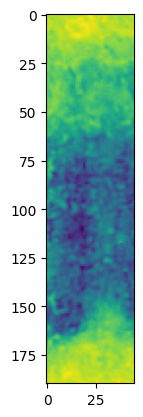

In [386]:
plt.imshow((((G-R)+(G+B))/ ((2*G)+R+B)))

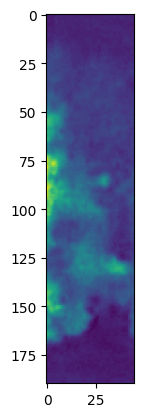

In [387]:
plt.imshow(((2*G-R-B)/(2*G+R+B)))

In [388]:
np.mean(((2*G-R-B)/(2*G+R+B)))

np.float64(0.03331369069926016)

In [406]:
def procces_stack_tiffv2(folder_path, grid_path, bands_n = None):
    """This function process all the .tiff files in a folder extracting the vegetation indexes and textures
    and stores the information in a dictionary where each key is the name of the raster file and values is a
    pandas dataframe with the information. Each file name must have the date info. Eg: 20240122_raster.tif .
    """

    tif_list = get_tiff_files(folder_path)
    features_dict = {}
    for tiff_pos, tiff_file in enumerate(tif_list):
        print(f"{tiff_pos + 1 }/{len(tif_list)} : {tiff_file}")
        features_dict[tiff_file] = extract_raster_data(
            folder_path + "/" + tiff_file, grid_path, bands_n)
    return features_dict



In [407]:
flight_folder = '/home/juan/Desktop/pynomic_project/Pynomics/add_on/flights'

In [410]:
vuelos = procces_stack_tiffv2(flight_folder, grid_path)

1/7 : 20180815_Lamberton_GCP_transparent_mosaic.tif
Raster Coords system: EPSG:32615
Grid Coords system: urn:ogc:def:crs:EPSG::32615
2/7 : 20180917_Lamberton_GCP_transparent_mosaic.tif
Raster Coords system: EPSG:32615
Grid Coords system: urn:ogc:def:crs:EPSG::32615
3/7 : 20180905_Lamberton_GCP_transparent_mosaic.tif
Raster Coords system: EPSG:32615
Grid Coords system: urn:ogc:def:crs:EPSG::32615
4/7 : 20180914_Lamberton_GCP_transparent_mosaic.tif
Raster Coords system: EPSG:32615
Grid Coords system: urn:ogc:def:crs:EPSG::32615
5/7 : 20180822_Lamberton_GCP_transparent_mosaic.tif
Raster Coords system: EPSG:32615
Grid Coords system: urn:ogc:def:crs:EPSG::32615
6/7 : 20180925_Lamberton_GCP_transparent_mosaic.tif
Raster Coords system: EPSG:32615
Grid Coords system: urn:ogc:def:crs:EPSG::32615
7/7 : 20180829_Lamberton_GCP_transparent_mosaic.tif
Raster Coords system: EPSG:32615
Grid Coords system: urn:ogc:def:crs:EPSG::32615


In [411]:
vuelos

{'20180815_Lamberton_GCP_transparent_mosaic.tif': {1: {'band_1': array([[236, 225, 220, ..., 213, 202, 199],
          [238, 227, 222, ..., 212, 202, 207],
          [229, 215, 214, ..., 216, 220, 223],
          ...,
          [209, 219, 219, ..., 213, 212, 220],
          [198, 212, 216, ..., 222, 220, 222],
          [193, 213, 217, ..., 223, 214, 217]], dtype=uint8),
   'band_2': array([[200, 191, 185, ..., 177, 166, 164],
          [201, 193, 187, ..., 176, 166, 170],
          [192, 181, 179, ..., 180, 184, 187],
          ...,
          [175, 184, 185, ..., 184, 182, 186],
          [164, 177, 182, ..., 191, 188, 189],
          [160, 178, 182, ..., 191, 182, 184]], dtype=uint8),
   'band_3': array([[161, 154, 147, ..., 141, 130, 128],
          [162, 156, 148, ..., 141, 129, 134],
          [152, 143, 141, ..., 144, 148, 151],
          ...,
          [139, 146, 147, ..., 142, 141, 147],
          [127, 139, 144, ..., 151, 148, 149],
          [124, 140, 145, ..., 151, 142, 143

In [393]:
import sys

In [402]:
sys.getsizeof(vuelos)

272